In [116]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt 

# Quasigeostrophic Comparison

### Maths Servers

In [117]:
import sys
sys.path.append('/home/links/ct715/eddy_feedback/') 
import functions.eddy_feedback as ef 
import functions.data_wrangling as data 

jra = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/jra55_daily/jra55_ubar_ep-both.nc',
                            parallel=True, chunks={'time': 31})

jra = jra.sel(time=slice('1958-03', '2016-11'))
jra = jra.resample(time='MS').mean('time')
jra = jra.isel(lat=slice(None, None, -1))
jra 

<xarray.Dataset>
Dimensions:  (time: 705, level: 37, lat: 73)
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) datetime64[ns] 1958-03-01 1958-04-01 ... 2016-11-01
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(1, 37, 73), meta=np.ndarray>
    div1_pr  (time, level, lat) float64 dask.array<chunksize=(1, 37, 73), meta=np.ndarray>
    div1_qg  (time, level, lat) float64 dask.array<chunksize=(1, 37, 73), meta=np.ndarray>

In [118]:
srip = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/srip_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

srip = srip.sel(time=slice('1958-03', '2016-11'))
# srip = srip.sel(time=srip.time.dt.month.isin([12,1,2]))

rename = {'pressure': 'level', 'latitude': 'lat'}
srip = srip.rename(rename)

srip 

<xarray.Dataset>
Dimensions:  (time: 705, level: 22, lat: 73)
Coordinates:
  * time     (time) datetime64[ns] 1958-03-14T09:00:00 ... 2016-11-13T21:00:00
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(29, 22, 73), meta=np.ndarray>
    div1_pr  (time, level, lat) float32 dask.array<chunksize=(29, 22, 73), meta=np.ndarray>
    div1_qg  (time, level, lat) float32 dask.array<chunksize=(29, 22, 73), meta=np.ndarray>

In [119]:
# set same levels in JRA55 as SRIP dataset
jra = jra.sel(level=srip.level.values)
jra 

<xarray.Dataset>
Dimensions:  (time: 705, level: 22, lat: 73)
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * time     (time) datetime64[ns] 1958-03-01 1958-04-01 ... 2016-11-01
Data variables:
    ubar     (time, level, lat) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    div1_pr  (time, level, lat) float64 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    div1_qg  (time, level, lat) float64 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>

### Zonal-mean zonal wind

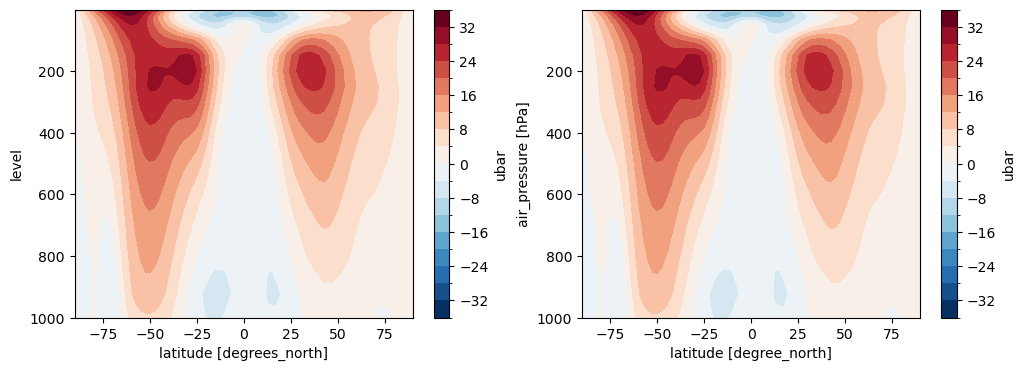

In [120]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))

jra.ubar.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False) 

srip.ubar.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False) 

plt.show() 

In [121]:
# np.testing.assert_allclose(jra.ubar.values, srip.ubar.values, rtol=1e-01)

- Visually similar
- However do not match with tolerance 1e-2 (20% not matching, and 3% mismatch with tol=0.1)

In [122]:
# cut off poles and upper-atmosphere
jra = jra.sel(level=slice(1000., 100.))
srip = srip.sel(level=slice(1000., 100.))

jra = jra.sel(lat=slice(-85, 85))
srip = srip.sel(lat=slice(-85, 85))

### QG Divergence of northward EP flux

Units do not match:

m/s/day --> m/s/s
- $60 \times 60 \times 24 = 86400$

In [123]:
# sort out units
jra.div1_qg # [m/s/day]
srip.div1_qg # [m s-2]

div1 = jra.div1_qg / 86400 

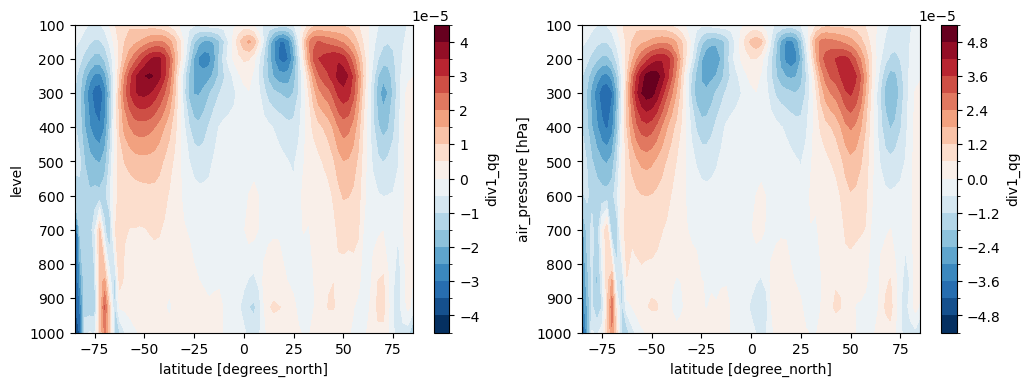

In [124]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))

div1.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False) 

srip.div1_qg.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False) 

plt.show() 

In [125]:
# np.testing.assert_allclose(div1.values, srip.div1_qg.values, rtol=1e-0)

- Again, visually similar.. slight differences in concentrations/strength in certain locations
- Mismatch in relative tolerance.. 50% mismatch at rtol=0.1 and 6% mismatch at rtol=1

# Full Primitive Comparison

In [126]:
# sort out units
jra.div1_pr # [m/s/day]
srip.div1_pr # [m s-2]

div1_pr = jra.div1_pr / 86400 

In [127]:
# SRIP dataset missing 1000hPa values for primitive version
div1_pr = div1_pr.where( div1_pr.level < 1000., drop=True)
div1_pr

<xarray.DataArray 'div1_pr' (time: 705, level: 11, lat: 69)>
dask.array<where, shape=(705, 11, 69), dtype=float64, chunksize=(2, 11, 69), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -85.0 -82.5 -80.0 -77.5 -75.0 ... 77.5 80.0 82.5 85.0
  * level    (level) float64 925.0 850.0 700.0 600.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 1958-03-01 1958-04-01 ... 2016-11-01

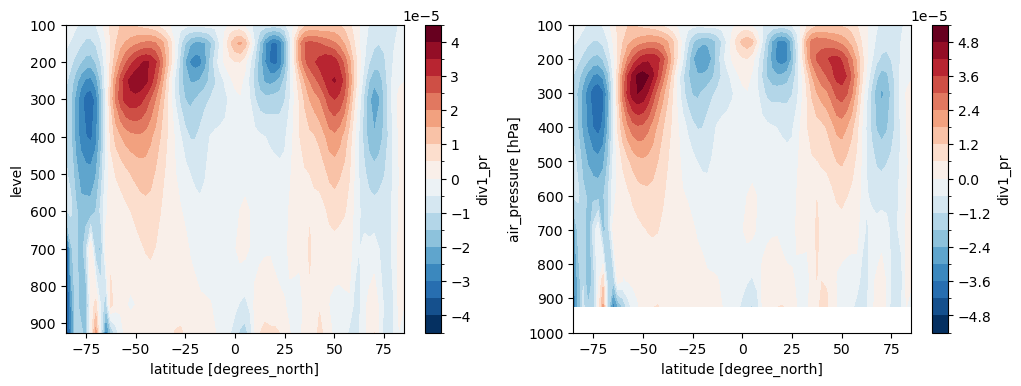

In [128]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))

div1_pr.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False) 

srip.div1_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False) 

plt.show() 

In [129]:
# np.testing.assert_allclose(div1.values, srip.div1_qg.values, rtol=1e-0)

In [130]:
srip.div1_pr.sel(level=1000.).values 

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)